In [2]:
import re
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from gensim.models import KeyedVectors
from sklearn.manifold import TSNE

%load_ext autoreload
%autoreload 2
%matplotlib inline

D:\Conda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
train = pd.read_csv('train_tweet.csv')
test = pd.read_csv('test_tweets.csv')

print(train.shape)
print(test.shape)

(31962, 3)
(17197, 2)


In [4]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [6]:
train.isnull().any()
test.isnull().any()

id       False
tweet    False
dtype: bool

In [7]:
# checking out the negative comments from the train set

train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [8]:
# checking out the postive comments from the train set 

train[train['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


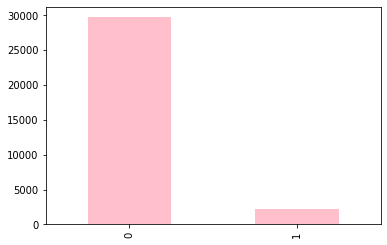

In [9]:
train['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))

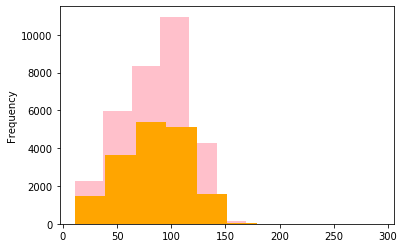

In [10]:
# checking the distribution of tweets in the data

length_train = train['tweet'].str.len().plot.hist(color = 'pink', figsize = (6, 4))
length_test = test['tweet'].str.len().plot.hist(color = 'orange', figsize = (6, 4))

In [11]:
# adding a column to represent the length of the tweet

train['len'] = train['tweet'].str.len()
test['len'] = test['tweet'].str.len()

train.head(10)

,id,label,tweet,len
0,1,0,@user when a father is dysfunctional and is s...,102
1,2,0,@user @user thanks for #lyft credit i can't us...,122
2,3,0,bihday your majesty,21
3,4,0,#model i love u take with u all the time in ...,86
4,5,0,factsguide: society now #motivation,39
5,6,0,[2/2] huge fan fare and big talking before the...,116
6,7,0,@user camping tomorrow @user @user @user @use...,74
7,8,0,the next school year is the year for exams.ð...,143
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,87
9,10,0,@user @user welcome here ! i'm it's so #gr...,50


In [12]:
train.groupby('label').describe()

id                                                               \
         count          mean          std   min      25%      50%       75%   
label                                                                         
0      29720.0  15974.454441  9223.783469   1.0  7981.75  15971.5  23965.25   
1       2242.0  16074.896075  9267.955758  14.0  8075.25  16095.0  24022.00   

                    len                                                        
           max    count       mean        std   min   25%   50%    75%    max  
label                                                                          
0      31962.0  29720.0  84.328634  29.566484  11.0  62.0  88.0  107.0  274.0  
1      31961.0   2242.0  90.187779  27.375502  12.0  69.0  96.0  111.0  152.0

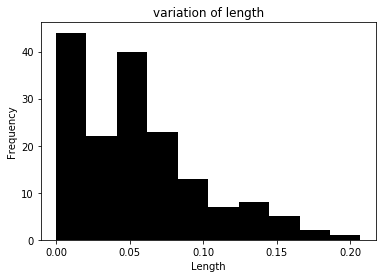

In [13]:
train.groupby('len').mean()['label'].plot.hist(color = 'black', figsize = (6, 4),)
plt.title('variation of length')
plt.xlabel('Length')
plt.show()

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

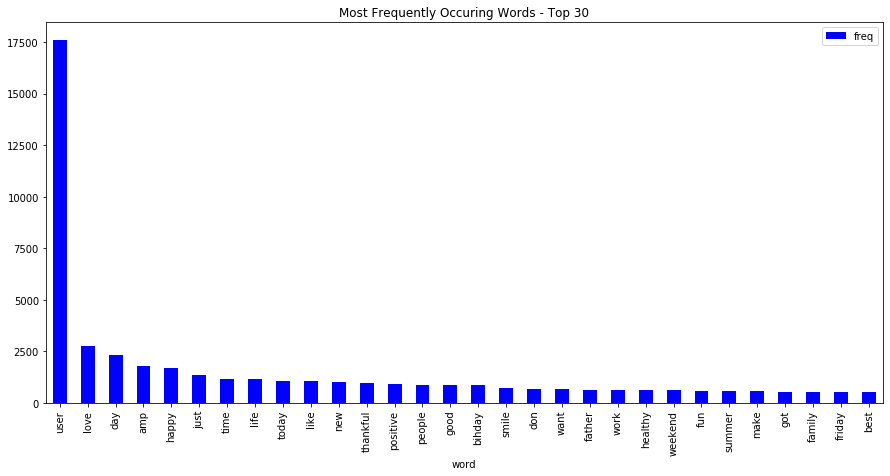

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.tweet)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")


Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

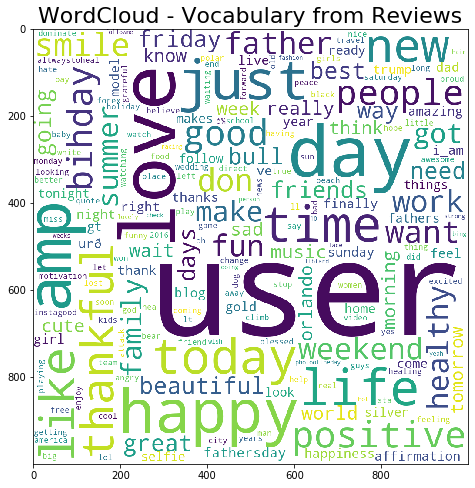

In [15]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

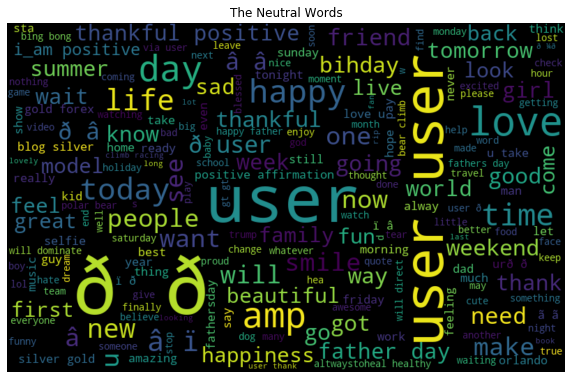

In [16]:
normal_words =' '.join([text for text in train['tweet'][train['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()


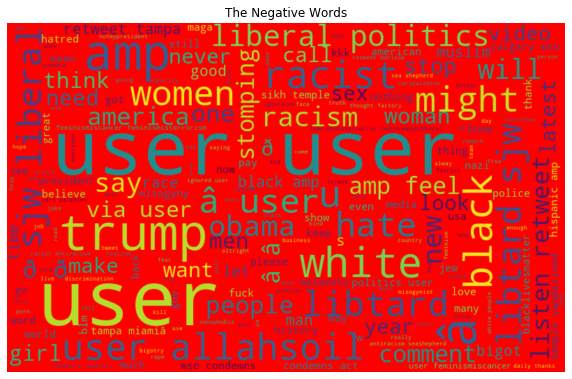

In [17]:
negative_words =' '.join([text for text in train['tweet'][train['label'] == 1]])

wordcloud = WordCloud(background_color = 'red', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()


In [18]:
# collecting the hashtags

def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [19]:
# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(train['tweet'][train['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(train['tweet'][train['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

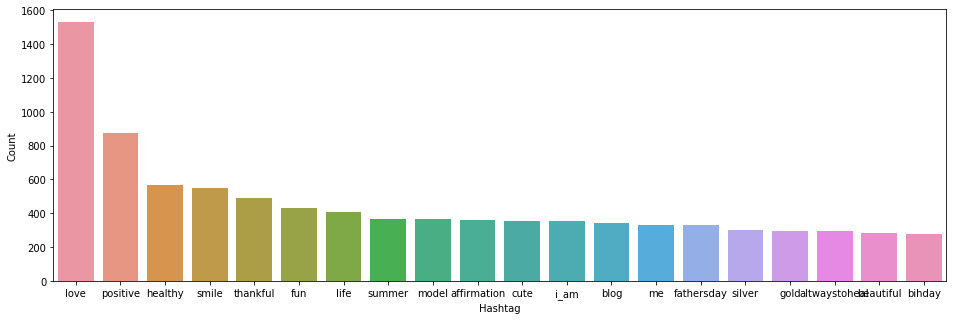

In [20]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

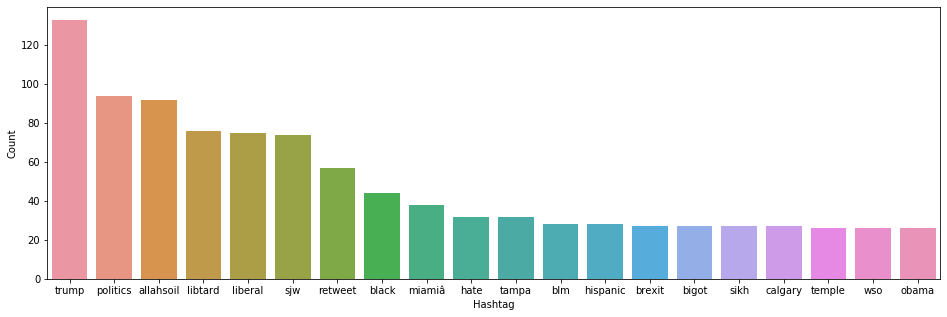

In [21]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [22]:
# tokenizing the words present in the training set
tokenized_tweet = train['tweet'].apply(lambda x: x.split()) 

# importing gensim
import gensim

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['tweet']), epochs=20)

(6111162, 8411580)

In [23]:
model_w2v.wv.most_similar(positive = "dinner")

[('spaghetti', 0.6308306455612183),
 ('#prosecco', 0.6138947010040283),
 ('#marbs', 0.603310763835907),
 ('sister!!', 0.5944268107414246),
 ('#wanderlust', 0.5901359915733337),
 ('#pamper', 0.5861304998397827),
 ('podium', 0.5850585699081421),
 ('bay.', 0.5803403258323669),
 ('crackers', 0.578312873840332),
 ('coaching', 0.5762838125228882)]

In [24]:
model_w2v.wv.most_similar(positive = "cancer")

[('ownership', 0.6976958513259888),
 ('speeches', 0.6976150274276733),
 ('#merica', 0.6973846554756165),
 ('extremist', 0.6918712854385376),
 ('behavior.', 0.6900085210800171),
 ('disregard', 0.6896131634712219),
 ('champion,', 0.6888367533683777),
 ('rights,', 0.6887240409851074),
 ('memes', 0.6884037256240845),
 ('roughly', 0.6881110668182373)]

In [25]:
model_w2v.wv.most_similar(positive = "apple")

[('"mytraining"', 0.6961143016815186),
 ('mytraining', 0.6888627409934998),
 ('training"', 0.6711496710777283),
 ('app,', 0.6232690215110779),
 ('"my', 0.6057543754577637),
 ('app', 0.5934041738510132),
 ('ios', 0.5769217014312744),
 ('heroku', 0.5609676241874695),
 ("domino's", 0.5594209432601929),
 ('#expressjs', 0.5507376194000244)]

In [26]:
model_w2v.wv.most_similar(negative = "hate")

[('#apple', 0.025289073586463928),
 ('#fundraising', -0.04238320514559746),
 ('#yay', -0.05885337293148041),
 ('currently', -0.06268441677093506),
 ('us.', -0.06377968937158585),
 ('final', -0.06468687951564789),
 ('#games', -0.06689736992120743),
 ('you?', -0.06763160228729248),
 ('#hype', -0.06871043890714645),
 ('#tech', -0.07206063717603683)]

In [27]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import TaggedDocument

D:\Conda\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [28]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output

# label all the tweets
labeled_tweets = add_label(tokenized_tweet)

labeled_tweets[:6]

[TaggedDocument(words=['@user', 'when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is', 'so', 'selfish', 'he', 'drags', 'his', 'kids', 'into', 'his', 'dysfunction.', '#run'], tags=['tweet_0']),
 TaggedDocument(words=['@user', '@user', 'thanks', 'for', '#lyft', 'credit', 'i', "can't", 'use', 'cause', 'they', "don't", 'offer', 'wheelchair', 'vans', 'in', 'pdx.', '#disapointed', '#getthanked'], tags=['tweet_1']),
 TaggedDocument(words=['bihday', 'your', 'majesty'], tags=['tweet_2']),
 TaggedDocument(words=['#model', 'i', 'love', 'u', 'take', 'with', 'u', 'all', 'the', 'time', 'in', 'urð\x9f\x93±!!!', 'ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91', 'ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦'], tags=['tweet_3']),
 TaggedDocument(words=['factsguide:', 'society', 'now', '#motivation'], tags=['tweet_4']),
 TaggedDocument(words=['[2/2]', 'huge', 'fan', 'fare', 'and', 'big', 'talking', 'before', 'they', 'leave.', 'chaos', 'and', 'pay', 'disputes', 'when', 'they', 'get', 'there.', '#allshowandnogo'],

In [29]:
# removing unwanted patterns from the data

import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
train_corpus = []

for i in range(0, 31962):
  review = re.sub('[^a-zA-Z]', ' ', train['tweet'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  train_corpus.append(review)

In [31]:
test_corpus = []

for i in range(0, 17197):
  review = re.sub('[^a-zA-Z]', ' ', test['tweet'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  test_corpus.append(review)

In [32]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(train_corpus).toarray()
y = train.iloc[:, 1]

print(x.shape)
print(y.shape)


(31962, 2500)
(31962,)


In [33]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x_test = cv.fit_transform(test_corpus).toarray()

print(x_test.shape)


(17197, 2500)


In [34]:
# splitting the training data into train and valid sets

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(23971, 2500)
(7991, 2500)
(23971,)
(7991,)


In [35]:
# standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [36]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Random Forest : ")
print("  Training Accuracy :", model.score(x_train, y_train))
print("  Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred))

#printing classifcationreport
cr=classification_report(y_valid,y_pred)
print(cr)

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Random Forest : 
  Training Accuracy : 0.999123941429227
  Validation Accuracy : 0.9524465023151045
F1 score : 0.6138211382113821
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      7432
           1       0.71      0.54      0.61       559

    accuracy                           0.95      7991
   macro avg       0.84      0.76      0.79      7991
weighted avg       0.95      0.95      0.95      7991

[[7309  123]
 [ 257  302]]


In [37]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Logistic Regression : ")
print("  Training Accuracy :", model.score(x_train, y_train))
print("  Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

#printing classifcationreport
cr=classification_report(y_valid,y_pred)
print(cr)

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

D:\Conda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression : 
  Training Accuracy : 0.9851487213716574
  Validation Accuracy : 0.9416843949443123
f1 score : 0.5933682373472949
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7432
           1       0.58      0.61      0.59       559

    accuracy                           0.94      7991
   macro avg       0.77      0.79      0.78      7991
weighted avg       0.94      0.94      0.94      7991

[[7185  247]
 [ 219  340]]


In [38]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Decision Tree Classifier :")
print("  Training Accuracy :", model.score(x_train, y_train))
print("  Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

#printing classifcationreport
cr=classification_report(y_valid,y_pred)
print(cr)

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Decision Tree Classifier :
  Training Accuracy : 0.9991656585040257
  Validation Accuracy : 0.9326742585408585
f1 score : 0.5432937181663837
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7432
           1       0.52      0.57      0.54       559

    accuracy                           0.93      7991
   macro avg       0.74      0.77      0.75      7991
weighted avg       0.94      0.93      0.93      7991

[[7133  299]
 [ 239  320]]


In [38]:
from sklearn.svm import SVC

model = SVC()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("SVC :")
print("  Training Accuracy :", model.score(x_train, y_train))
print("  Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
#print("f1 score :", f1_score(y_valid, y_pred))

#printing classifcationreport
cr = classification_report(y_valid,y_pred)
print(cr)

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

SVC :
  Training Accuracy : 0.978181969880272
  Validation Accuracy : 0.9521962207483419
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7432
           1       0.94      0.34      0.50       559

    accuracy                           0.95      7991
   macro avg       0.94      0.67      0.74      7991
weighted avg       0.95      0.95      0.94      7991

[[7419   13]
 [ 369  190]]


In [37]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("XGB Classifier :")
print("  Training Accuracy :", model.score(x_train, y_train))
print("  Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
#print("f1 score :", f1_score(y_valid, y_pred))

#printing classifcationreport
cr=classification_report(y_valid,y_pred)
print(cr)

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

D:\Conda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:15:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Classifier :
  Training Accuracy : 0.9603687789412206
  Validation Accuracy : 0.9555750218996371
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7432
           1       0.87      0.43      0.57       559

    accuracy                           0.96      7991
   macro avg       0.91      0.71      0.78      7991
weighted avg       0.95      0.96      0.95      7991

[[7396   36]
 [ 319  240]]
